In [1]:
import requests
import json
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import Choropleth, Circle, Marker, Icon, Map
from folium.plugins import HeatMap, MarkerCluster
from pymongo import MongoClient
client = MongoClient("localhost:27017")
import src.visualizations as vi
import src.cleaning as cl
import src.calls as ca
from dotenv import load_dotenv
load_dotenv()

True

## 1. Select the relevant offices in London from the database 

Connect to the Lab database in MongoDB

In [2]:
client.list_database_names()
db = client.get_database("Lab")

Open the companies collection from the database

In [3]:
companies = db.get_collection("Oficina")

Select the columns to show in the queries 

In [4]:
proj = {"_id" : 0, "name" : 1, "total_money_raised" : 1, "category_code" : 1, "number of employees" : 1, "founded_year" : 1, "total_money_raised" : 1, "offices.latitude" : 1, "offices.longitude" : 1}

Make a query of the offices in London that raised more than 1 million in any currency

In [5]:
london_companies = list(companies.find({"offices.city": "London", "total_money_raised" : {"$gte":"$1.M"}}, proj))

Create a DataFrame with the companies

In [6]:
df_london = pd.DataFrame(london_companies)

Get a list of all the latitudes from the response of the request 

In [7]:
list_latitudes_london = [company['offices'][0]['latitude'] for company in london_companies]

Get a list of all the longitudes from the response of the request 

In [8]:
list_longitudes_london = [company['offices'][0]['longitude'] for company in london_companies]

Add a column with the latitudes to the DataFrame

In [9]:
df_london['latitude'] = list_latitudes_london

Add a column with the longitudes to the DataFrame

In [10]:
df_london['longitude'] = list_longitudes_london

Drop the offices column

In [11]:
df_london.drop(['offices'], axis = 1, inplace = True)

The query to the MongoDB returned some companies that raised less than 1 million. In order to get only the ones that did, create a regex pattern and create a new column that will store only those. 

The ones that raised less than 1 million will be substituted by "not found", using a try/except. 

In [12]:
# Pattern to select any digit that starts with the USD, EUR or LB symbol. 
# Then digits, 0 or more (I tried with the + for one or more, but it didn't work)
# Followed by a point
# Again 0 or more digits
# And finishing with an M
pattern = r'([$€£]\d*.\d*M)'

In [13]:
df_london['millions_raised'] = df_london['total_money_raised'].apply(lambda x: cl.selecting_millions(pattern, x))

Replace the columns with 'not found' with NaN, so those  rows can be deleted.

In [14]:
df_london['millions_raised'].replace(['not found'], np.nan, inplace = True)

Delete the columns with an NaN, as they do not meet the criteria of having raised more than 1 million. 

In [15]:
df_london.dropna(how = 'any', axis = 0, inplace = True) 

This is the dataframe with the companies that raised more than 1 million, either in dollars, euros or pounds

In [16]:
df_london.head()

,name,category_code,founded_year,total_money_raised,latitude,longitude,millions_raised
0,Babelgum,games_video,2007.0,$13.2M,53.344104,-6.267494,$13.2M
1,OpenX,advertising,2008.0,$75.5M,34.149471,-118.132747,$75.5M
2,Google,search,1998.0,$555M,37.421972,-122.084143,$555M
3,Skype,software,2003.0,$76.8M,51.518132,-0.131916,$76.8M
5,KickApps,enterprise,2004.0,$32M,40.751661,-73.984333,$32M


This graph was created to have a general idea of the type of companies that raised more than 1 million. 

There are plenty related with tecnology. 

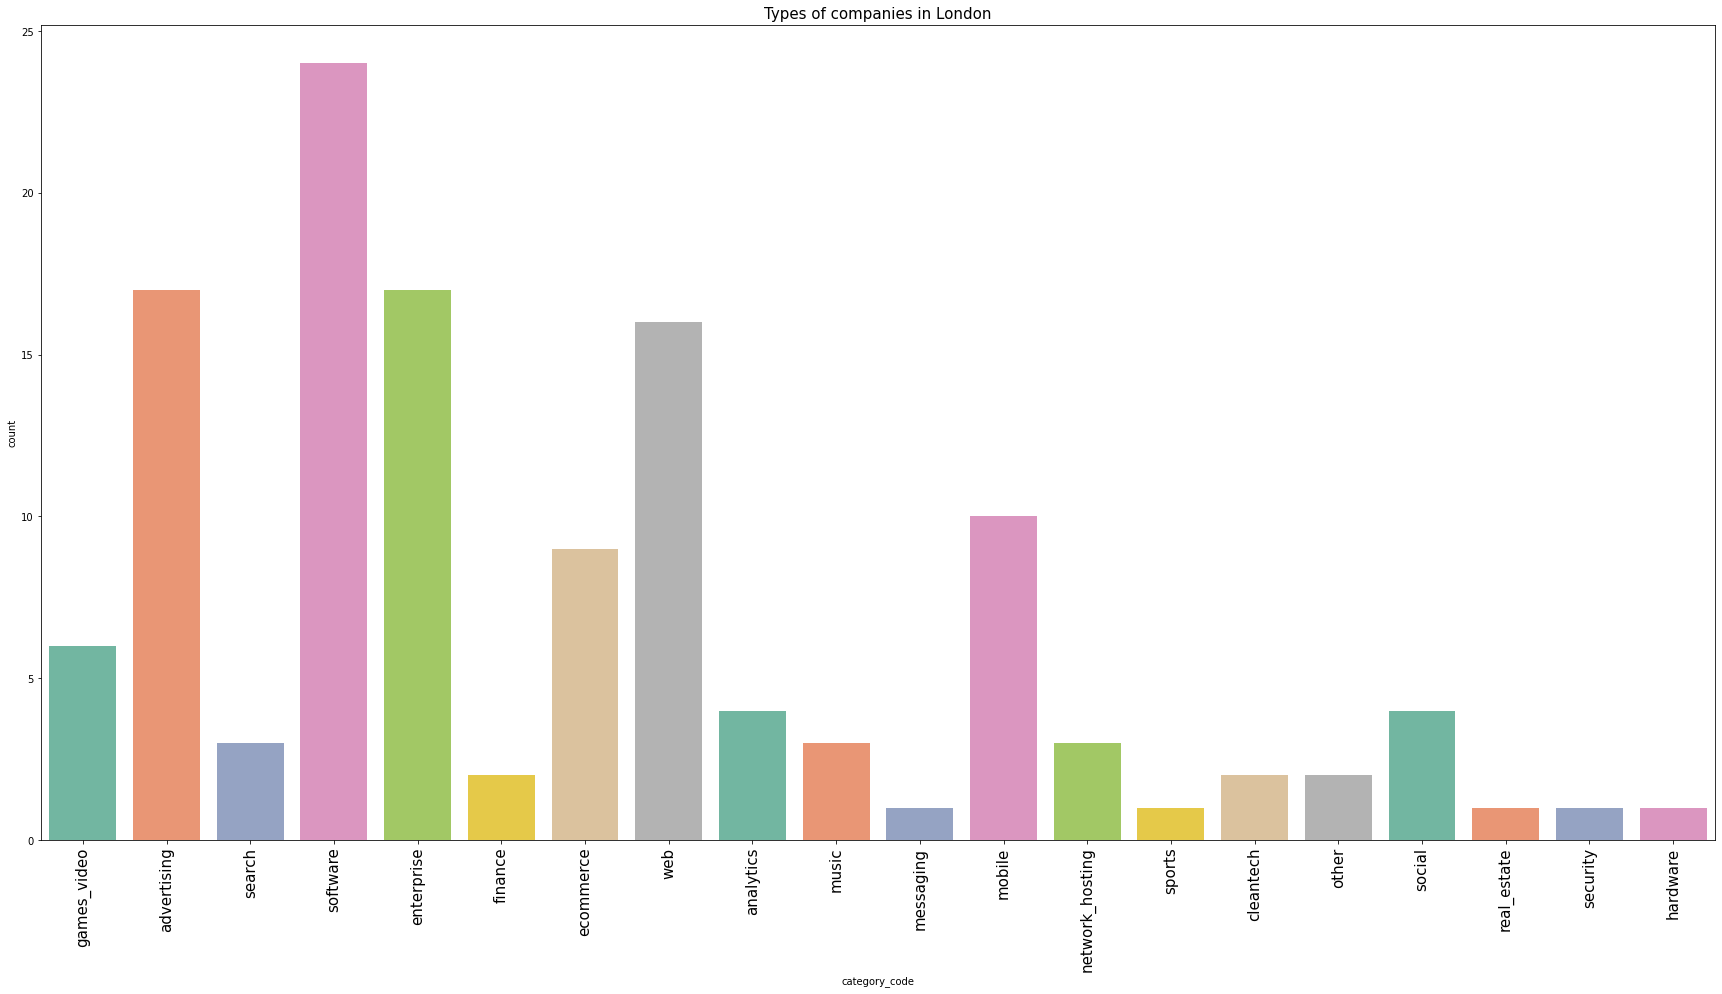

In [17]:
vi.histogram((30, 15), df_london, "category_code", "Types of companies in London")

Select the companies that are relevant and desired to be close from the location. 

In [18]:
df_london_categories = df_london[(df_london['category_code'] == "games_video") | (df_london['category_code'] == "software") | (df_london['category_code'] == "ecommerce") | (df_london['category_code'] == "web") | (df_london['category_code'] == "analytics") | (df_london['category_code'] == "music") | (df_london['category_code'] == "mobile") | (df_london['category_code'] == "social") | (df_london['category_code'] == "design")] 

Create a map of London and mark the places of the companies that fit the categories

In [19]:
london_lat = 51.509865
london_lon = -0.118092

In [20]:
london_map = folium.Map(location = [london_lat, london_lon], zoom_start = 14)

Add the companies from the filtered dataframe in the map, to see how they are distributed.

In [21]:
for i, row in df_london_categories.iterrows():
    distrito = {"location":[row["latitude"], row["longitude"]],
                "tooltip" : [row["name"], row["category_code"]]}
    if row["name"] == "Skype":
        icon = Icon(color = "blue",
                            prefix = "fa",
                            icon = "briefcase",
                            icon_color = "black")
    else:
        icon = Icon(color = "green",
                            prefix = "fa",
                            icon = "briefcase",
                            icon_color = "black")

    Marker(**distrito,icon = icon).add_to(london_map)

This map shows the location of the companies that meet the criteria of the category and the raised amount of money from the collection. 

There are two nearby areas with groups of companies. The selected one is in blue, which belongs to Skpye. 

This is going to be the location used for the geolocations, and finally evaluated and compared to other locations in Berlin and Paris. 

In [22]:
london_map

Save the map as html

In [45]:
london_map.save('london_map.jpg')

In [23]:
london_map.save('london_map.html')

## 2. Make the geoqueries 

Once the location has been selected, make geoqueries to Foursquare to see how many venues are nearby. 

The venues to be checked are:

- Starbucks 
- Schools (both preschool and elementary school)
- Theaters 
- Basketball stadiums 
- Restaurants (with vegan and vegetarian options)
- Cinemas
- Nightlife locations
- Gyms or fitness centers

Create a type Point with the coordinates of the location in London.

In [25]:
london_skype = {'type': 'Point', 'coordinates': [51.518132, -0.131916]}

On the following lines, the same operation will be repeated:

1. Make a query to Foursquare using a function
2. Create a DataFrame with the response using a function
3. Convert the DataFrame into a json file and save it so it can be stored as a MongoDB collection. 

In [26]:
london_starbucks = ca.make_call(london_skype, "Starbucks")
df_starbucks_london = ca.make_df(london_starbucks)
df_starbucks_london.to_json("starbucks_london.json", orient="records")

In [27]:
df_near_starbucks_london = ca.check_near("Lab","starbucks_london", -0.131916, 51.518132, 1000)

In [28]:
london_preschools = ca.make_call(london_skype, "Preschool")
df_preschools_london = ca.make_df(london_preschools)
df_preschools_london.to_json("schools_london.json", orient="records")

In [29]:
london_elementary_schools = ca.make_call(london_skype, "Elementary School")
df_elementary_schools_london = ca.make_df(london_elementary_schools)
df_elementary_schools_london.to_json("e_schools_london.json", orient="records")

Here the distance was increased 300 metres, to have more than one result. 

In [30]:
df_near_schools_london = ca.check_near("Lab","schools_london", -0.131916, 51.518132, 1300)

In [31]:
london_theater = ca.make_call(london_skype, "Theater")
df_theater_london = ca.make_df(london_theater)
df_theater_london.to_json("theater_london.json", orient="records")

In [32]:
df_near_theater_london = ca.check_near("Lab","theater_london", -0.131916, 51.518132, 1000)

This query had no response, so it was saved as 0 (in order to be calculated in the score).

In [33]:
london_basketball = ca.make_call(london_skype, "Basketball Stadium")
df_basketball_london = ca.make_df(london_basketball)

In [34]:
df_near_basketball_london = df_basketball_london

In [35]:
london_restaurants = ca.make_call(london_skype, "Vegetarian / Vegan Restaurant")
df_restaurants_london = ca.make_df(london_restaurants)
df_restaurants_london.to_json("restaurants_london.json", orient="records")

In [36]:
df_near_restaurants_london = ca.check_near("Lab","restaurants_london", -0.131916, 51.518132, 1000)

In [37]:
london_nightlife = ca.make_call(london_skype, "Nightlife Spot")
df_nightlife_london = ca.make_df(london_nightlife)
df_nightlife_london.to_json("nightlife_london.json", orient="records")

In [38]:
df_near_nightlife_london = ca.check_near("Lab","nightlife_london", -0.131916, 51.518132, 500)

In [39]:
london_cinema = ca.make_call(london_skype, "Movie Theater")
df_cinema_london = ca.make_df(london_cinema)
df_cinema_london.to_json("cinema_london.json", orient="records")

In [40]:
df_near_cinema_london = ca.check_near("Lab","cinema_london", -0.131916, 51.518132, 1000)

In [41]:
london_gym = ca.make_call(london_skype, "Gym / Fitness Center")
df_gym_london = ca.make_df(london_gym)
df_gym_london.to_json("gym_london.json", orient="records")

In [42]:
df_near_gym_london = ca.check_near("Lab","gym_london", -0.131916, 51.518132, 1000)

## 3. Calculate a score

The score for each location is calculated in a range between 0 and 10, and eight categories are taken into account. 

This is the maximum value for each category. Depending on the amount of each category in the proximity of the location, the value will be higher. 

For example, the more Starbucks near the office, the higher the value that will be added to the total score. 

- Starbucks = 1.25
- Schools = 2.25
- Theaters = 1
- Basketball stadiums = 0.5
- Restaurants = 1.25
- Cinemas = 1
- Nightlife locations = 1.5
- Gyms or fitness centers = 1.25

Each of the categories has been divided in 4, and a fraction of the total value has been assigned to each part. 

For example, with Starbucks:

If the amout of Starbucks is 0, it would receive 0 points. 

If it is between 1 and 10, it will get a value of 0.5 from the total 1.25. 

If it is between 10 and 20, it will receive 1. 

Finally, it the amount is higher it will get the total 1.25 on that category. 

The amounts were decided for each category, checking the maximum values on the three cities. They can be adapted for new cities if necessary. 

In [43]:
cl.score(df_near_starbucks_london, df_near_schools_london, df_near_theater_london, df_near_basketball_london, 
         df_near_restaurants_london, df_near_nightlife_london, df_near_cinema_london, df_near_gym_london)

8.35